## Importing Libraries

In [31]:
import tpot
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [32]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

## Saving Dataset

In [33]:
train_data = pd.DataFrame(X_train, columns=iris.feature_names)
train_data['target'] = y_train
test_data = pd.DataFrame(X_test, columns=iris.feature_names)
test_data['target'] = y_test

train_data.to_csv('iris_train.csv', index=False)
test_data.to_csv('iris_test.csv', index=False)

## AutoML using TPOT

In [34]:
tpot_classifier = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42)
tpot_classifier.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.975

Generation 2 - Current best internal CV score: 0.975

Generation 3 - Current best internal CV score: 0.975

Generation 4 - Current best internal CV score: 0.9833333333333334

Generation 5 - Current best internal CV score: 0.9833333333333334

Best pipeline: GaussianNB(MultinomialNB(input_matrix, alpha=10.0, fit_prior=False))


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

## Save Best Pipeline

In [35]:
pipeline_filename = 'best_pipeline.py'
tpot_classifier.export(pipeline_filename)

with open(pipeline_filename, 'r') as file:
    pipeline_code = file.read()

pipeline_code = pipeline_code.replace("COLUMN_SEPARATOR", ",")

with open(pipeline_filename, 'w') as file:
    file.write(pipeline_code)


## Save Trained Model

In [36]:
joblib.dump(tpot_classifier.fitted_pipeline_, 'best_model.joblib')

['best_model.joblib']

## Evaluation of Model

### 1. Accuracy

In [37]:
accuracy = tpot_classifier.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 1.0


### 2. Confusion Matrix

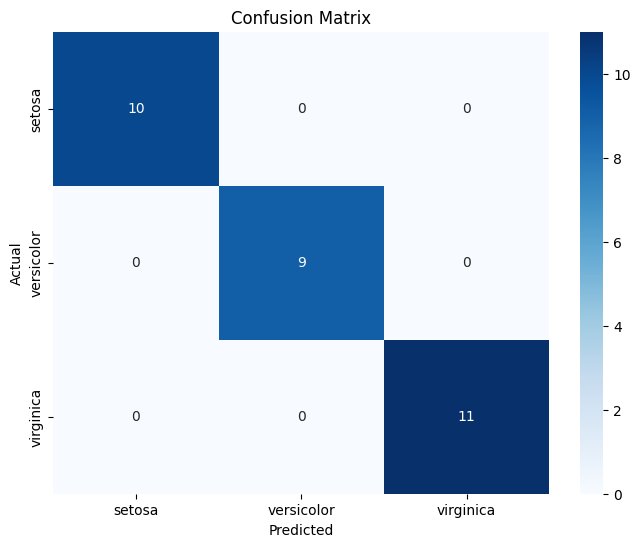

In [38]:
y_pred = tpot_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 3. Classification Report

In [39]:
class_report = classification_report(y_test, y_pred, target_names=iris.target_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### 4. ROC-Curve

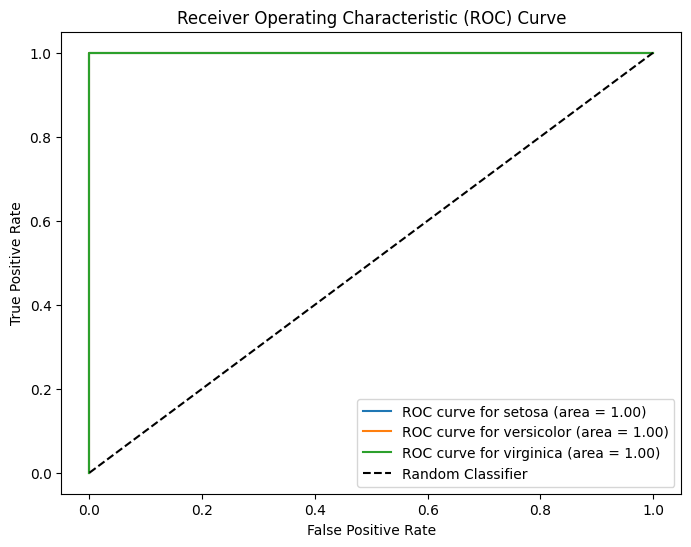

In [40]:
y_score = tpot_classifier.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(iris.target_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {iris.target_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()